In [1]:
from tqdm.notebook import tqdm
import astropy.constants as const
import pylab as plt
from astropy.modeling import models
from astropy import units as u
from astropy.visualization import quantity_support
import numpy as np
import scipy.stats
import pylab as plt
import math
from scipy.stats import norm
import astropy
from astropy.modeling import models
from astropy import units as u
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

M_sun = const.M_sun.cgs.value

In [2]:
def max_mass(t):
    t_sun = 1e10 * u.yr #10 Gy
    mass_max = ((t_sun/t).value)**(1/2.5)
    return mass_max

def Properties(M):
    L_sun = const.L_sun.cgs.value
    R_sun = const.R_sun.cgs.value
    M_sun = const.M_sun.cgs.value
    sigma = const.sigma_sb.cgs.value
    
    eta = 3.5 #exponent of the mass-luminosity relation
    xi = 0 #exponent of the mass-radius relation
    
    if (M.any() >= 1.2 * M_sun): 
        xi = 0.56 #cno cycle
    else:
        xi = 0.43 #pp chain
    
    R_M_relation = xi
    R = R_sun*((M/M_sun)**(xi))
    
    L_M_relation = eta
    L = L_sun*((M/M_sun)**(eta))*(u.erg/u.s)
    
    Temp = (L / (4*(math.pi)*(R**2*(u.cm**2))*sigma*(u.erg/((u.K**4)*(u.cm**2)*u.s))))**(1/4)
    
    numb_stars = (M/M_sun)**(-2.35)
    S = 4*(math.pi)*(R/R_sun)**2
    scale_factor = numb_stars*S
    #scale_factor = numb_stars
    
    
    return Temp, scale_factor

def SBB_Flux(minlog_age, maxlog_age, n_ages):
    
    max_mass_array = np.empty([1, len(ages)])
    
    max_mass_array = max_mass(ages_gyr)
    min_mass = 0.1

    flux = np.empty([n_ages, len(wave)])

    for i in range (0, len(ages)):
        Mass = np.linspace(min_mass, max_mass_array[i], 100) 
        Mass = Mass*M_sun 

        Temp, scale_factor = Properties(Mass)

        bb = np.sum([models.BlackBody(temperature=Temperature, scale=S_F *(u.erg/(u.cm**2 * u.AA * u.s * u.sr))) for Temperature, S_F in zip(Temp, scale_factor)])
        
        flux[i] = bb(wave*u.AA)/bb(5500*u.AA) #normalizzato a f(5500)

    return flux
    

def Mitigation(flux_int, wave, n_ebv):

    flux_obs = np.empty([n_ebv, len(wave)])
    mitigation_factor = np.empty(n_ebv)
    
    for i in range(0, len(ebv)):
        
        r_v = 4.05
        k = 0
        wave = wave*10**(-4) #passo da angstrom a micrometri
    
        if wave.any() > 0.12 and wave.any() < 0.63:
            k = 2.659*(-2.156 + (1.509/wave.any()) - (0.198/wave.any()**2) + 0.011/(wave.any()**3)) + r_v
        elif wave.any() > 0.63 and wave.any() < 2.2:
            k = 2.659*(-1.857 + 1.040/wave.any()) + r_v
        
        a_lambda = k*ebv[i]
    
        flux_obs[i] = flux_int*10**(-0.4*a_lambda)
        mitigation_factor[i] = 10**(-0.4*a_lambda)
    
    return flux_obs, mitigation_factor

In [3]:
wave = np.arange(3500, 7500)

minlog_age = 0
maxlog_age = 1
n_ages = 6

ages = np.logspace(minlog_age, maxlog_age, n_ages)
ages_gyr = ages*u.yr*(10**9)

flux = SBB_Flux(minlog_age, maxlog_age, n_ages)

print(flux)
print(wave)

[[1.47819628 1.4781384  1.47808008 ... 0.5724376  0.57227837 0.57211919]
 [1.24089386 1.24101891 1.24114351 ... 0.61919363 0.61903898 0.61888436]
 [1.0162768  1.0165411  1.01680498 ... 0.67733799 0.67719077 0.67704358]
 [0.80946343 0.80982043 0.81017712 ... 0.75053387 0.75039856 0.75026325]
 [0.62488178 0.62528562 0.6256893  ... 0.84391526 0.84379889 0.8436825 ]
 [0.46577109 0.46618036 0.46658961 ... 0.96480973 0.96472343 0.96463711]]
[3500 3501 3502 ... 7497 7498 7499]


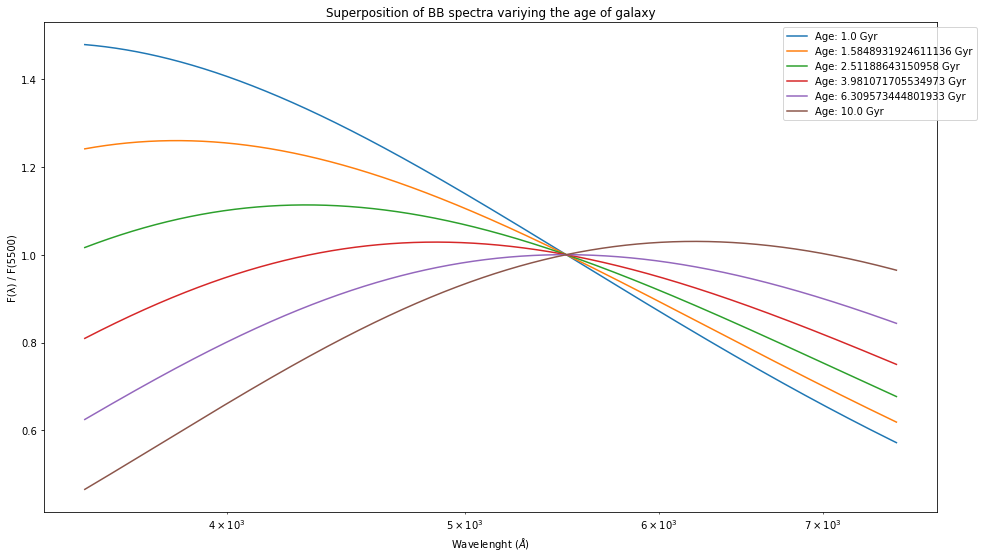

In [4]:
plt.figure(figsize=(16,9))

for i in range (0, n_ages):
    plt.semilogx(wave, flux[i], label = 'Age: {} Gyr'.format((ages[i])))
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Wavelenght ($\AA$)')
    plt.ylabel('F(\u03BB) / F(5500)')
    plt.grid()

plt.title('Superposition of BB spectra variying the age of galaxy')
plt.show()

In [5]:
n_ebv = 5
ebv = np.linspace(0.1, 1, num=n_ebv)

flux_obs, mitigation_factor = Mitigation(flux[0], wave, n_ebv)

print(ebv)
print(flux_obs)
print(mitigation_factor)

[0.1   0.325 0.55  0.775 1.   ]
[[1.24344971 1.24340102 1.24335196 ... 0.48153103 0.48139708 0.48126318]
 [0.8426447  0.84261171 0.84257846 ... 0.32631763 0.32622686 0.32613612]
 [0.57103242 0.57101006 0.57098753 ... 0.22113466 0.22107315 0.22101165]
 [0.38696977 0.38695461 0.38693935 ... 0.14985564 0.14981395 0.14977228]
 [0.2622366  0.26222633 0.26221598 ... 0.1015522  0.10152396 0.10149572]]
[0.84119391 0.57004926 0.38630352 0.2617851  0.1774031 ]


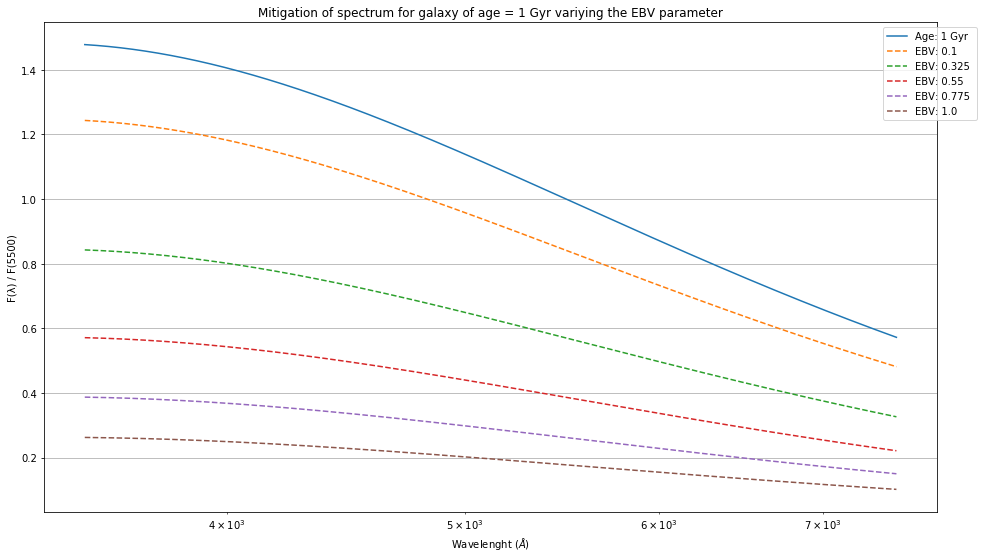

In [6]:


plt.figure(figsize=(16,9))
plt.semilogx(wave, flux[0], label = 'Age: 1 Gyr')

for i in range (0, n_ebv):
    plt.semilogx(wave, flux_obs[i], label = 'EBV: {} '.format((ebv[i])), linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Wavelenght ($\AA$)')
    plt.ylabel('F(\u03BB) / F(5500)')
    plt.grid()

plt.title('Mitigation of spectrum for galaxy of age = 1 Gyr variying the EBV parameter')
plt.show()